In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import catboost
import xgboost as xgb
import glob

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import optimizers
from keras import regularizers

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
STATUS = './status.csv'
DESCR = './comment.xlsx'
SAMPLE = './sample submission.csv'
TEST = './test.csv'
FLAT = './flat.csv'
PRICE = './price.csv'
TRAIN = './train.csv'

# Import data

In [3]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

# Main handler

In [4]:
def handler(data, test=False):
    
    ds = data.copy(deep=True)
    cols = ds.columns
    
    # Extract categorical data
    categorical_columns = list(set(train.columns) - set(train._get_numeric_data().columns))


    # One hot encoding categorical cols
    for col in categorical_columns:
        if ((ds[col][0] == "да") or (ds[col][0] == "нет")):
            ds[col] = ds[col].map(lambda x: 1 if (x == "да") else 0).copy(deep=True)
            
    # Normalizing
    ds["Количество помещений"] = (ds["Количество помещений"] / 5579).copy(deep=True) # max
    ds["price"] = (ds["price"] / 300000).copy(deep=True) # max
    ds["Детский сад"] = (ds["Детский сад"] / 1000).copy(deep=True) # max
    ds["Машиномест"] = (ds["Машиномест"] / 10000).copy(deep=True) # max
    ds["Площадь пром. зоны в радиусе 500 м"] = (ds["Площадь пром. зоны в радиусе 500 м"] / 378372).copy(deep=True)
    ds["Площадь зеленой зоны в радиусе 500 м"] = (ds["Площадь зеленой зоны в радиусе 500 м"] / 516706).copy(deep=True)
    ds["Площадь двора"] = (ds["Площадь двора"] / 16473).copy(deep=True) # max
    ds["Школа"] = (ds["Школа"] / 3250).copy(deep=True) # max
    ds["Поликлиника"] = (ds["Поликлиника"] / 600).copy(deep=True) # max
    
    # Create year columns
    #ds["year"] = ds["date1"][0:4].copy(deep=True)
    
    # Object class one hot encoding
    ohoc = pd.get_dummies(ds["Класс объекта"]) # One hot object class
    for col in ohoc:
        ds[col] = ohoc[col].copy(deep=True)
    
    # Delete useless columns 
    del ds["bulk_id"]
    if (test == False):
        del ds["plan_s"]
        del ds["plan_m"]
        del ds["plan_l"]
        del ds["vid_0"]
        del ds["vid_1"]
        del ds["vid_2"]
        del ds["start_square"]
    del ds["date1"]
    del ds["id"]
    del ds["Лифт"]
    del ds["Спортивная площадка"]
    del ds["Входные группы"]
    del ds["Система мусоротведения"]
    del ds["Класс объекта"]
    
    return ds

# CV splitter

In [166]:
def get_train_test(train, sz=0.2):
    X = train.copy(deep=True)
    y = X["value"]
    del X["value"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sz)

    return X_train, X_test, y_train, y_test

In [167]:
newds = handler(train) # test, test=True
newds_tst = handler(test, test=True) # test, test=True

In [168]:
X_train, X_test, y_train, y_test = get_train_test(newds, sz=0.1)

In [169]:
X_train.head()

,spalen,price,mean_sq,mean_fl,month,month_cnt,Количество помещений,Огорожена территория,Площадь земельного участка,Детский сад,...,Станций метро от кольца,Площадь двора,Курс,Cтавка по ипотеке,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,комфорт,стандарт,эконом
4087,0,0.365208,27.13,5,2,26,0.660513,0,41.00,0.900,...,8.0,0.369271,58.539361,11.76,6.40,6.94,7.69,0,0,1
1683,0,0.478167,20.72,8,6,30,1.000000,0,20.60,0.660,...,9.0,0.498027,57.893176,11.26,5.73,6.42,7.97,1,0,0
8535,1,0.595605,38.26,9,12,24,0.648324,0,35.00,0.650,...,4.0,0.391125,62.091291,12.21,6.75,7.16,8.50,1,0,0
8337,0,0.699358,19.80,15,8,32,0.153253,0,3.40,0.000,...,4.0,0.107995,59.612726,10.87,6.19,6.70,7.76,1,0,0
8141,0,0.525571,25.10,18,3,27,0.077433,0,4.68,0.125,...,10.0,0.242822,58.006632,11.88,5.94,6.81,6.63,1,0,0



# CatBoost

In [170]:
n = 50
models = []
bagging_errors = []
for i in range(n):
    d = random.randint(3, 9)
    itr = random.randint(2000, 3000)
    l2lr = random.uniform(0.5, 5)
    bt = random.uniform(0.5, 1)
    print("Training model ", i + 1, "/", n, " with depth=", d, " ...", sep="")
    X_train, X_test, y_train, y_test = get_train_test(newds, sz=0.2)
    models.append(catboost.CatBoostRegressor(bagging_temperature=bt,
                                             l2_leaf_reg=l2lr,
                                             loss_function="RMSE",
                                             iterations=itr,
                                             depth=d,
                                             verbose=False).fit(X_train, y_train))
    bag_ret = (sum((models[i].predict(X_test) - y_test) ** 2) / len(X_test)) ** (1/2)
    bagging_errors.append(bag_ret)
    print(sum(bagging_errors) / (i + 1), end="\n\n")
print("Total baggin error:", sum(bagging_errors) / n)

Training model 1/50 with depth=7 ...
218.80750558327628

Training model 2/50 with depth=5 ...
238.02279662174314

Training model 3/50 with depth=4 ...
244.82114202909509

Training model 4/50 with depth=6 ...
243.2006710764648

Training model 5/50 with depth=5 ...
244.8631997750722

Training model 6/50 with depth=6 ...
242.0069334639376

Training model 7/50 with depth=8 ...
239.43975780914232

Training model 8/50 with depth=5 ...
240.15989023775103

Training model 9/50 with depth=7 ...
239.74923567437332

Training model 10/50 with depth=9 ...
239.4111252740062

Training model 11/50 with depth=8 ...
239.83140356036859

Training model 12/50 with depth=6 ...
241.58971234178628

Training model 13/50 with depth=4 ...
243.78966634147542

Training model 14/50 with depth=8 ...


KeyboardInterrupt: 

In [160]:
random.uniform(0.5, 4)

2.8141188309072245

In [121]:
bag_return = []
for model in models:
    bag_return.append(model.predict(newds_tst))

In [134]:
(np.sum(bag_return, axis=0) / len(bag_return))

array([651.55871405, 952.53885833, 333.08086269, ..., 155.78016929,
       -90.13417307,  18.4383555 ])

In [137]:
pd.DataFrame({"id":range(len(newds_tst)), "value":(np.sum(bag_return, axis=0) / len(bag_return))}).to_csv("./cb-noparams20.csv",
                                                                                  encoding="utf-8",
                                                                                  index=False)

# Невязки ошибки дерева, надо уменьшать variance

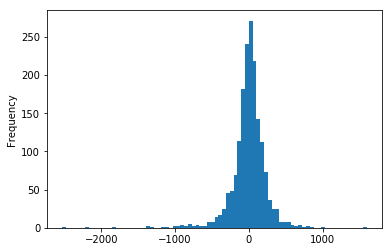

In [11]:
(cbr.predict(X_test) - y_test).plot.hist(bins=80)

In [12]:
X_train.columns

Index(['spalen', 'price', 'mean_sq', 'mean_fl', 'month', 'month_cnt',
       'Количество помещений', 'Огорожена территория',
       'Площадь земельного участка', 'Детский сад', 'Школа', 'Поликлиника',
       'ФОК', 'Автомойка', 'Кладовые', 'Колясочные', 'Кондиционирование',
       'Вентлияция', 'Видеонаблюдение', 'Подземная парковка', 'Двор без машин',
       'Машиномест', 'Площадь пром. зоны в радиусе 500 м',
       'Площадь зеленой зоны в радиусе 500 м', 'До Кремля', 'До ТТК(км)',
       'До Садового(км)', 'До большой дороги на машине(км)',
       'До удобной авторазвязки на машине(км)', 'До метро пешком(км)',
       'До промки(км)', 'До парка(км)', 'До парка пешком(км)',
       'Станций метро от кольца', 'Площадь двора', 'Курс', 'Cтавка по ипотеке',
       'Вклады до 1 года', 'Вклады от 1 года до 3 лет', 'Вклады свыше 3 лет',
       'комфорт', 'стандарт', 'эконом'],
      dtype='object')

In [59]:
pd.DataFrame({"id":range(len(newds_tst)), "value":cbr.predict(newds_tst)}).to_csv("./cb-noparams18.csv",
                                                                                  encoding="utf-8",
                                                                                  index=False)

# XGBoost

In [86]:
xgbm = xgb.XGBRegressor(max_depth=6)
xgbm.fit(X_train, y_train)
(sum((xgbm.predict(X_test) - y_test) ** 2) / len(X_test)) ** (1/2)

270.92984308393665

In [85]:
pd.DataFrame({"id":range(len(newds_tst)), "value":xgbm.predict(newds_tst)}).to_csv("./cb-noparams19.csv",
                                                                                   encoding="utf-8",
                                                                                   index=False)

# Нейросеть на Keras

In [24]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [144]:
nn = Sequential()
nn.add(Dense(43, kernel_regularizer=regularizers.l2(1), activation="selu", input_shape=(43, )))
nn.add(Dense(43, kernel_regularizer=regularizers.l2(1), activation="selu", input_shape=(35, )))
nn.add(Dense(1,  activation="linear", input_shape=(43, )))
opt = optimizers.sgd(lr=0.001, momentum=0.01)
nn.compile(optimizer=opt, loss="mae", metrics=["mae"])
history = nn.fit(X_train, y_train, epochs=80)

Epoch 1/80
6972/6972 [==============================] - 1s 148us/step - loss: 283.6422 - mean_absolute_error: 224.5612
Epoch 2/80
6972/6972 [==============================] - 0s 51us/step - loss: 248.9649 - mean_absolute_error: 223.2673
Epoch 3/80
6972/6972 [==============================] - 0s 53us/step - loss: 234.9825 - mean_absolute_error: 223.1264
Epoch 4/80
6972/6972 [==============================] - 0s 51us/step - loss: 229.3397 - mean_absolute_error: 223.1250
Epoch 5/80
6972/6972 [==============================] - 0s 54us/step - loss: 226.5574 - mean_absolute_error: 222.5577
Epoch 6/80
6972/6972 [==============================] - 0s 54us/step - loss: 224.8628 - mean_absolute_error: 221.5570
Epoch 7/80
6972/6972 [==============================] - 0s 56us/step - loss: 224.5999 - mean_absolute_error: 221.2717
Epoch 8/80
6972/6972 [==============================] - 0s 51us/step - loss: 224.0239 - mean_absolute_error: 220.3000
Epoch 9/80
6972/6972 [==============================] -

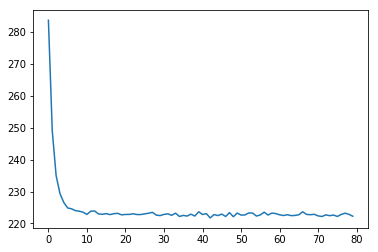

In [145]:
plt.plot(range(history.history["loss"].__len__()), history.history["loss"])

In [143]:
(sum((nn.predict(X_test).reshape(1, -1)[0] - y_test) ** 2) / len(X_test)) ** (1/2)

407.99802816540983

In [148]:
nn.predict(X_test)

array([[ 90.682274],
       [173.67583 ],
       [141.31877 ],
       ...,
       [199.4697  ],
       [182.31056 ],
       [154.75804 ]], dtype=float32)